# Modelo de Predicción

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency, f_oneway
import matplotlib.pyplot as plt
import warnings
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
#import bootcampviztools as bt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor


In [ ]:
epcc23 = pd.read_csv("../data/epcc23.csv")

In [ ]:
epcc23.head()

,Idioma_preferencia,Residencia_habitual,Quienes_conviven,Cuantos_menores,Cuantas_horas_audiovisuales_ayer,Horas_internet_ayer,Grado_interes_videojuegos,Media_horas_juego_semanal,Multijugador,Juego_nocturno,...,Motivo_visita_biblioteca,Tareas_realizadas,Ambito_asociacionismo,Idioma_en_internet,Usos_internet,Conceptos_asociados_videojuegos,Lengua_habitual_hogar,Dominio_linguistico,valores_positivos_videojuegos,valores_negativos_videojuegos
0,2,3,4,2.0,3.0,3.0,9,2.0,1.0,1.0,...,6,10,0,3,"3,4","1,2,5","1,2,3","1,2,3","[2, 3.0]","[4, 1.0]"
1,2,3,4,1.0,3.0,4.0,10,14.0,1.0,1.0,...,0,0,0,2,"3,4,7","1,2,5",2,1,"[3, 4.0]","[1, 3.0]"
2,1,3,4,2.0,3.0,3.0,8,3.0,0.0,0.0,...,2,2,0,"2,3","3,4",2,1,1,"[1, 3.0]","[6, 1.0]"
3,1,3,5,2.0,5.0,3.0,8,3.0,1.0,0.0,...,2,"1,7",0,2,"3,4","1,2,5","1,2",1,"[3, 2.0]","[4, 1.0]"
4,1,3,0,0.0,4.0,3.0,9,15.0,1.0,1.0,...,2,7,0,"1,2","3,4","1,4,8",1,"1,2","[3, 5.0]","[3, 6.0]"


-------------------------------------

In [ ]:
# Por si acaso, hago una copia
epcc23co = epcc23.copy()

In [ ]:
# Examino el df
epcc23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4115 entries, 0 to 4114
Columns: 117 entries, Idioma_preferencia to valores_negativos_videojuegos
dtypes: float64(43), int64(28), object(46)
memory usage: 3.7+ MB


II. Prediccion con Regresión

Ahora vamos a intentar predecir los diferentes targets para nuestros usuarios.

Recordamos que los targets son:


Targets:

In [ ]:
var_targets = ["Media_horas_juego_semanal", "Horas_musica_ayer", "Cuantos_conciertos_año", "Cuantos_festivales_año", "Cuantas_pelis_3_meses", "Cuantos_espectaculos_año",
           "Cuantas_visitas_museo", "Cuantas_visitas_galeria_arte", "Cuantas_visitas_salas_expos", "Cuantas_visitas_monumentos", "Cuantas_expos_otros", "Cuantos_libros_año"]

Que las vuelvo a agrupar como en el clustering:

In [ ]:
# Agrupar las variables objetivo en nuevas columnas, que son mis targets
epcc23['VJ'] = epcc23['Media_horas_juego_semanal']
epcc23['MU'] = epcc23['Horas_musica_ayer']
epcc23['CO_FE'] = epcc23['Cuantos_conciertos_año'] + epcc23['Cuantos_festivales_año']
epcc23['CI'] = epcc23['Cuantas_pelis_3_meses']
epcc23['ES'] = epcc23['Cuantos_espectaculos_año']
epcc23['EX'] = (epcc23['Cuantas_visitas_museo'] +
                epcc23['Cuantas_visitas_galeria_arte'] +
                epcc23['Cuantas_visitas_salas_expos'] +
                epcc23['Cuantas_visitas_monumentos'] +
                epcc23['Cuantas_expos_otros'])
epcc23['LI'] = epcc23['Cuantos_libros_año']

# Lista de variables objetivo agrupadas
targets = ['VJ', 'MU', 'CO_FE', 'CI', 'ES', 'EX', 'LI']

EDA y preprocesamiento de datos

Antes de dividir en train y test vamos a procesar los datios de varias formas, una sola vez para todos, y solo luego dividiremos en train y test

Primero veamos un histograma para cada uno de los targets

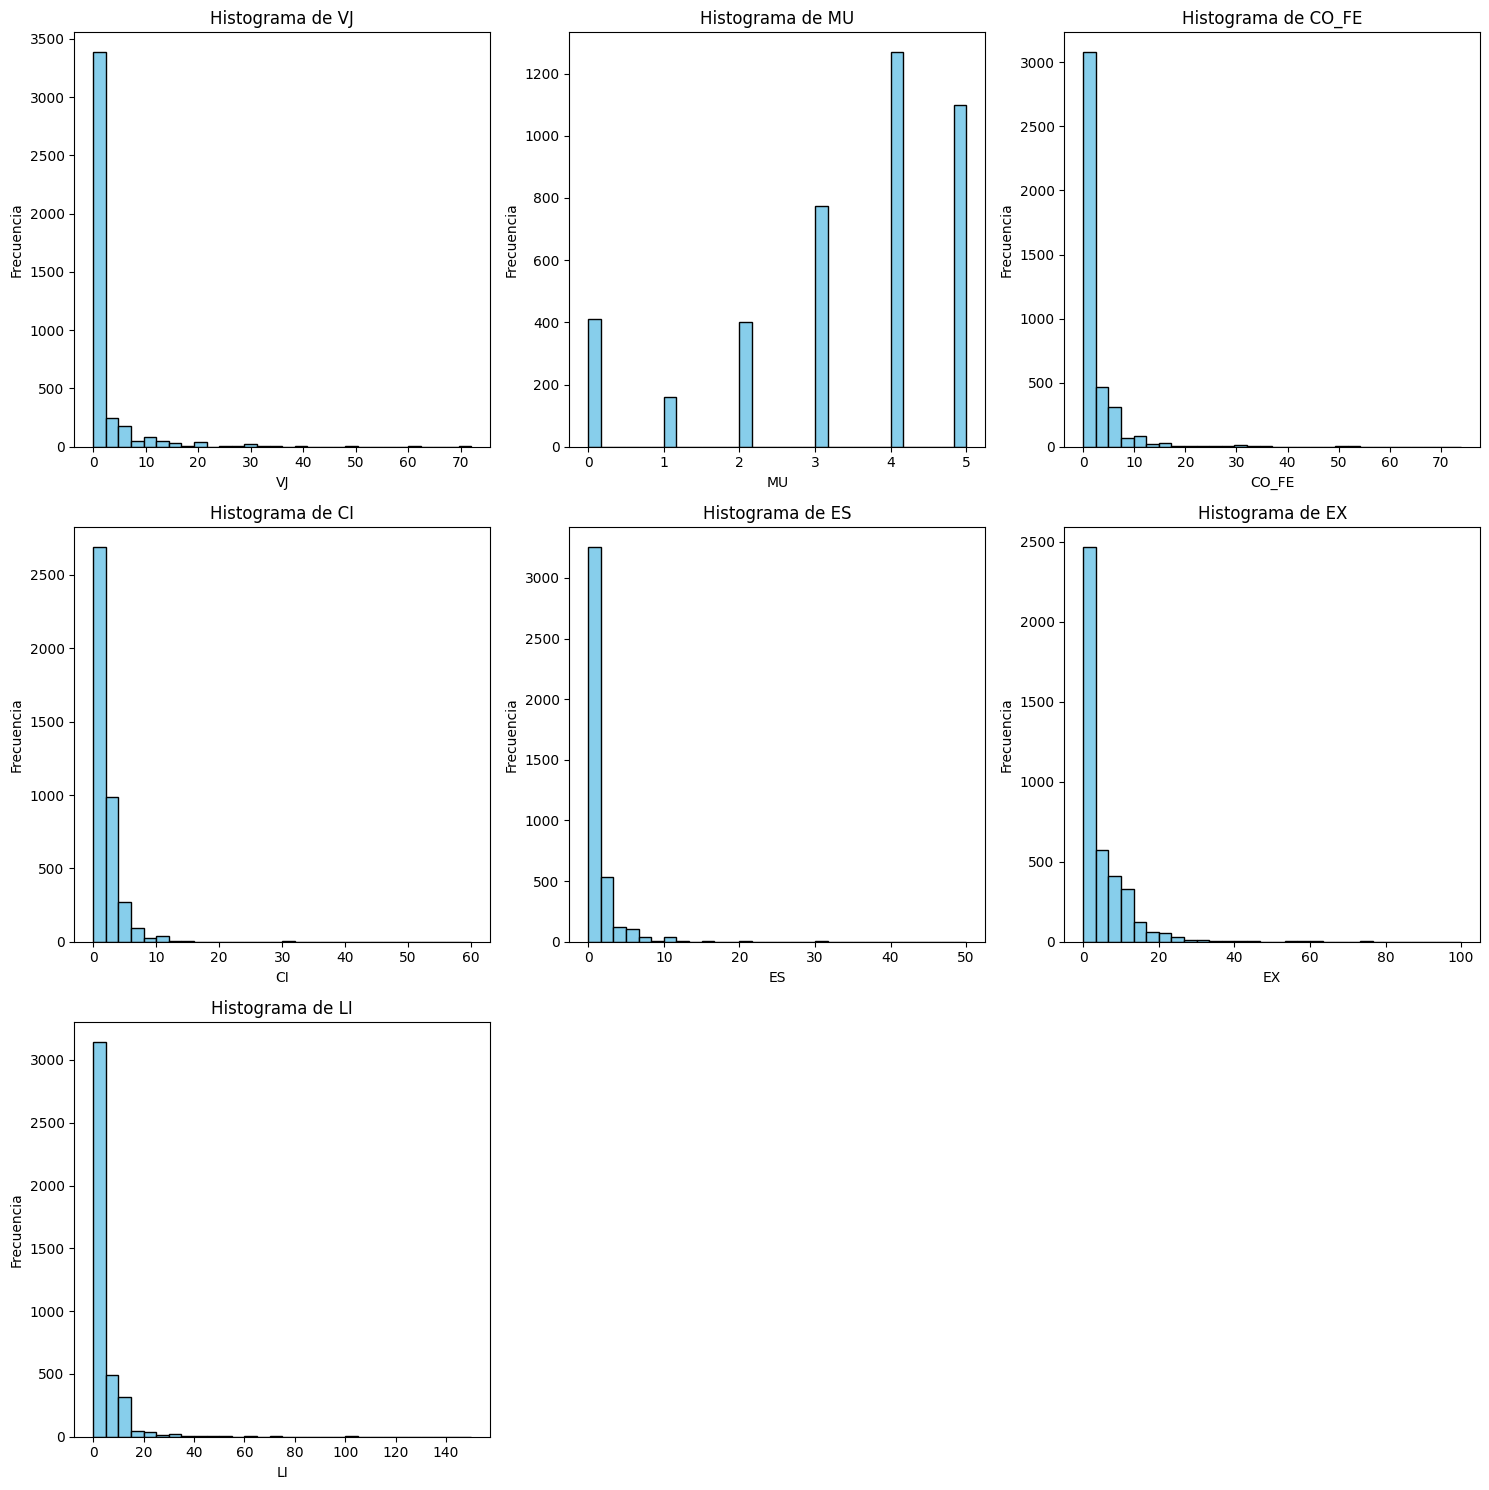

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

axes = axes.flatten()

# Generar un histograma para cada target
for i, target in enumerate(targets):
    axes[i].hist(epcc23[target], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histograma de {target}')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel('Frecuencia')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Primero voy a hacer un pequeño EDA, empezando ahora por un breve análisis multivariante. Para ello, solo he seleccionado algunas de las features que, en la etapa del clustering, salieron como más relevante en varias ocasiones, ya que no me detendré en hacer la comparativa entre las más de 100 columnas de mi df, puesto que no tiene sentido semenjante inversión de recursos, sobre todo habiendo tenido un vistazo general de las más relevantes en el clustering.

Las he dividido en categóricas (la mayoría), y numéricas (un par):

EDA

Teniendo en cuenta que:
* el paso anterior de Clusterización ya ha supuesto análisis de datos,  reducción de dimensionalidad, etc.,
* y que, por otro lado, el df tiene aún más de 100 columnas y 7 targets,

En este apartado vamos a avanzar un poco más en esta dirección, pero no voy a hacer un contraste de cada una de las 100 features contra cada uno de los 7 targets, ya que ello requeriría muchos más recursos de tiempo y análisis de los cuento para la ejecución de este proyecto.

Lo que sí haré, en primer lugar, será unificar ciertas columnas de similar significación, como las relativas a los usos de la lengua, a los motivos por los que no realiza cierta actividad cultural, los ingresos del padre y de la madre, y similiares

In [ ]:
uso_lenguas_unif = ['Lengua_chatear', 'idioma_biblioteca', 'Lenguas_en_casa', 'Idioma_en_internet',
                    'Lengua_trabajo', 'Lengua_deportes', 'Lengua_tiendas', 'Lengua_restauracion', 'Lengua_medicos']

# Crear una nueva columna 'Lengua' con el valor más frecuente (moda) de las columnas especificadas
epcc23['Lengua_uso'] = epcc23[uso_lenguas_unif].mode(axis=1)[0]

In [ ]:
estudios_padres_unif = ['Estudios_padre', 'Estudios_madre']

epcc23['Estudios_padres'] = epcc23[estudios_padres_unif].mode(axis=1)[0]

In [ ]:
motivos_no_unif = ['Por_que_no_juega_videojuegos', 'Motivos_no_escucha_musica', 'Motivos_no_va_a_conciertos', 'Motivos_no_va_al_cine',
                       'Motivos_no_ve_espectaculos', 'Motivos_no_visita_museos', 'Motivos_no_lee',]

epcc23['Motivos_no'] = epcc23[motivos_no_unif].mode(axis=1)[0]

In [ ]:
con_quien_unif = ['Con_quien_cine', 'Con_quien_concierto', 'Con_quien_espectaculos', 'Con_quien_expos']

epcc23['Con_quien'] = epcc23[con_quien_unif].mode(axis=1)[0]

In [ ]:
var_cat = ['Quienes_conviven', 'Estudios_acabados', 'Tam_Mun', 'Situacion_laboral', 'Idioma_preferencia', 'Residencia_habitual', 'Multijugador',
           'Juego_nocturno', 'Frecuencia_compra_dentro_juego','Usos_internet', 'Impacto_VJ_en_hijo_menor', 'Macrofestivales', 'Version_pelis',
           'Feria_festival_libros', 'Cuando_visita_expos', 'Tipo_museo_expo',  'Donde_ultimo_museo', 'idioma_asociacion', 'Idioma_libros',
           'Escucha_audiolibros', 'Cual_fue_primera_lengua', 'Lengua_habitual', 'Lengua_indentitaria', 'Donde_nacio', 'Nacionalidad',
           'Origen_padre', 'Origen_madre', 'Regimen_laboral', 'Profesion', 'Sexo', 'Sustentador_principal', 'Situacion_laboral_sust_ppal',
           'Estudios_sust_ppal', 'Convivientes_con_ingresos', 'Tareas_realizadas', 'Amb_Terr', 'Formato_diario_ayer', 'Idioma_diarios_ayer',
           'Formato_revistas_ayer', 'Idioma_revistas_ayer', 'Formato_radio_ayer', 'Idioma_radio_ayer', 'Como_ha_visionado', 'Tipo_de_programas',
           'Lenguas', 'Gratis_Pagos_Descargas', 'Lengua_pelis_series',  'Soporte', 'Idioma_vj', 'Generos_vj', 'Personajes_que_faltan',
           'Donde_compra_VJ', 'Cuales_competencias_VJ', 'Idioma_música', 'Estilo_musica', 'Soporte_musica', 'Idioma_co', 'Estilo_musica_co',
           'Genero_libros',  'Idioma_cn', 'Generos_cine', 'Idioma_es', 'Actividades_en_museos', 'Como_se_entero_ex', 'Como_se_entero_li',
           'Motivo_visita_biblioteca', 'Ambito_asociacionismo','valores_negativos_videojuegos', 'Conceptos_asociados_videojuegos',
           'Lengua_habitual_hogar', 'Dominio_linguistico', 'valores_positivos_videojuegos', 'Lengua_uso', 'Estudios_padres', 'Motivos_no', 'Con_quien']
var_num = ['Ingresos_totales_hogar', 'Edad', 'Cuantos_menores', 'Cuantas_horas_audiovisuales_ayer', 'Horas_internet_ayer',
           'Importe_anual_compras_dentro_VJ', 'Grado_interes_videojuegos', 'Cuantos_festivales_escenicas_año', 'Cuantos_audiolibros',
           'Libros_educativos_profesionales', 'Ingresos_personales']


In [ ]:
codigos_quienes_conviven = {
    1: "Unipersonal",
    2: "Dos_persones_y_mas",
    3: "Pareja_sin_hijos",
    4: "Pareja_con_hijos",
    5: "Madre_o_padre_con_hijos",
    6: "Hogar_co_2_o_mas_nucleos_familiares",
    0: "NS/NC"
}

codigos_estudios_acabados = {
    1: "Sin_acabar_estudios_obligatorios",
    2: "Obligatorios",
    3: "Secundarios_generales",
    4: "Secundarios_profesionales",
    5: "Universitarios",
    6: "Post_universitarios",
    0: "NS/NC"
}

codigos_lengua_uso = {
    0: "No_realiza_la_actividad",
    1: "Solo_CAT",
    2: "Mas_CAT_que_ES",
    3: "Igual_CAT_ES",
    4: "Mas_ES que CAT",
    5: "Solo_ES",
    6: "Otro_idioma_o_combinacion",
    0: "NS/NC"
}

grandaria_municipi = {
    'FINS A 2.000': 1,
    'DE 2.001 A 10.000': 2,
    'DE 10.001 A 50.000': 3,
    'MÉS DE 50.000 - RESTA CATALUNYA': 4,
    'BARCELONA CIUTAT': 5
}

codigos_situacion_laboral = {
    1: "Trabaja",
    2: "En_paro",
    2: "Estudiante",
    4: "Jubilado_discapacitado",
    5: "Trabajo_no_remunerado",
    0: "NS/NC"
}

codigos_estudios_padres = {
    1: "Sin_estudios_obligatorios",
    2: "Obligatorios",
    3: "Secundarios_generales",
    4: "Secundarios_profesionales",
    5: "Universitarios",
    6: "Post_universitarios",
    0: "NS/NC",
}

codigos_ingresos_totales_hogar = {
    1: "Menos_1000€",
    2: "1001-1500€",
    3: "1501-2500€",
    4: "2501-3500€",
    5: "3501-4500€",
    6: "4501-6000€",
    7: "Mas_6000€",
    0: "NS/NC"
}

age_mapping = {
    '14-19': 0,
    '20-24': 1,
    '25-34': 2,
    '35-54': 3,
    '>=55': 4
}

In [ ]:
mapeos = {
    'Quienes_conviven': codigos_quienes_conviven,
    'Estudios_acabados': codigos_estudios_acabados,
    'Lengua_uso': codigos_lengua_chatear,
    'Tam_Mun': codigos_ingresos_totales_hogar,
    'Situacion_laboral': codigos_situacion_laboral,
    'Estudios_padres': codigos_estudios_madre,
    'Ingresos_totales_hogar': codigos_ingresos_totales_hogar
}

Si bien no voy a hacer un análisis univariante ni bivariante detallado por el alto volumen de variable, sí quiero tener una idea general de las relaciones que puede haber entre mis targets y las categóricas por un lado, y las numéricas por otro.

Vamos a empezar por explorar las categóricas, y para ello voy a usar el test de Chi-2, a ver cuáles variables tienen un p_value inferior al 0.05 que indique que influye efectivamente en mis targets.

In [ ]:
def calcular_chi2(cat_vars, targets, df):
    resultados_chi2 = []
    for var in cat_vars:
        for target in targets:
            tabla_contingencia = pd.crosstab(df[var], df[target])
            chi2, p, _, _ = chi2_contingency(tabla_contingencia)
            resultados_chi2.append((var, target, chi2, p))
    return pd.DataFrame(resultados_chi2, columns=['Variable', 'Target', 'Chi2', 'P-Value'])

resultados_chi2 = calcular_chi2(var_cat, targets_agrupados, epcc23)

resultados_significativos = resultados_chi2[resultados_chi2['P-Value'] < 0.05]

print("Asociaciones significativas entre variables categóricas y targets:")
print(resultados_significativos)


Asociaciones significativas entre variables categóricas y targets:
              Variable Target         Chi2        P-Value
0     Quienes_conviven     VJ   249.738774   1.590497e-02
1     Quienes_conviven     MU   185.120729   2.893027e-24
3     Quienes_conviven     CI   208.767442   2.104276e-08
7    Estudios_acabados     VJ   335.929534   1.647647e-08
8    Estudios_acabados     MU   158.327815   2.196167e-19
..                 ...    ...          ...            ...
527          Con_quien  CO_FE  4065.013385   0.000000e+00
528          Con_quien     CI  1287.723252  4.433740e-201
529          Con_quien     ES  1831.156757  5.422098e-311
530          Con_quien     EX  1835.446689  7.782044e-207
531          Con_quien     LI  2727.661912   0.000000e+00

[368 rows x 4 columns]


Y voy a graficar solo algunas tablas de contingencia donde parecería haber algunas relaciones interesantes entre variables y targets.

Veamos en términos relativos, ya que la muestra puede ser desigual para diferentes segmentos de los entrevistados:

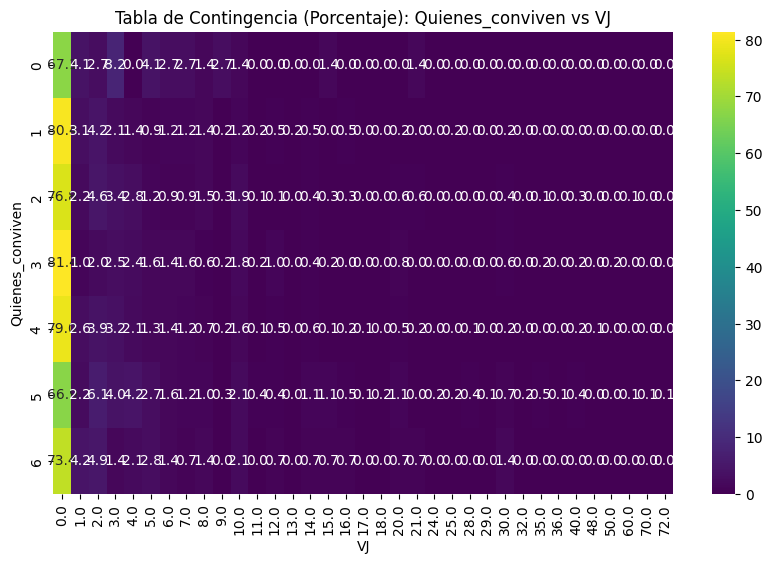

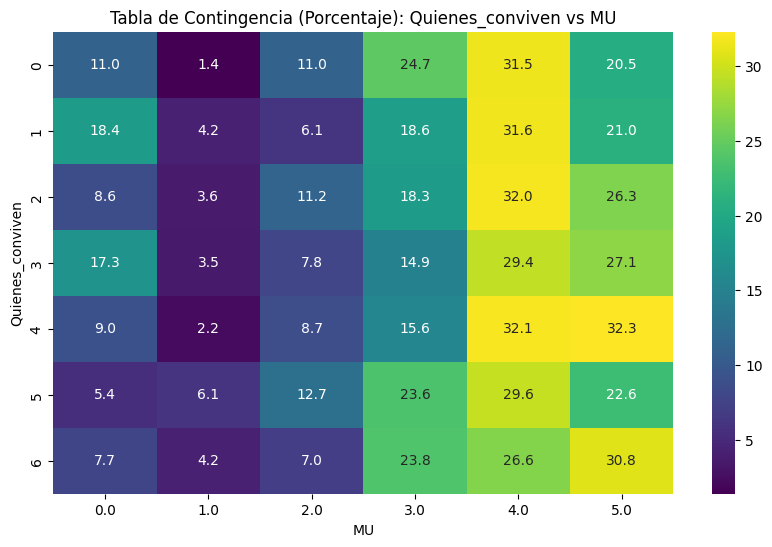

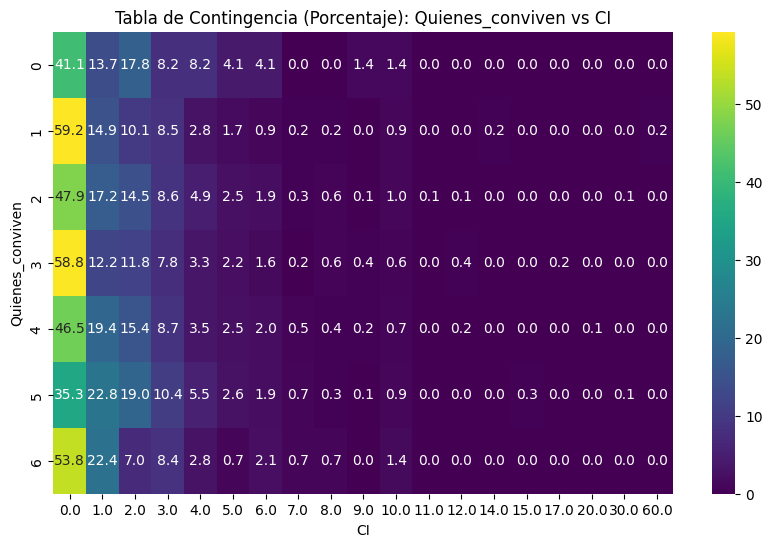

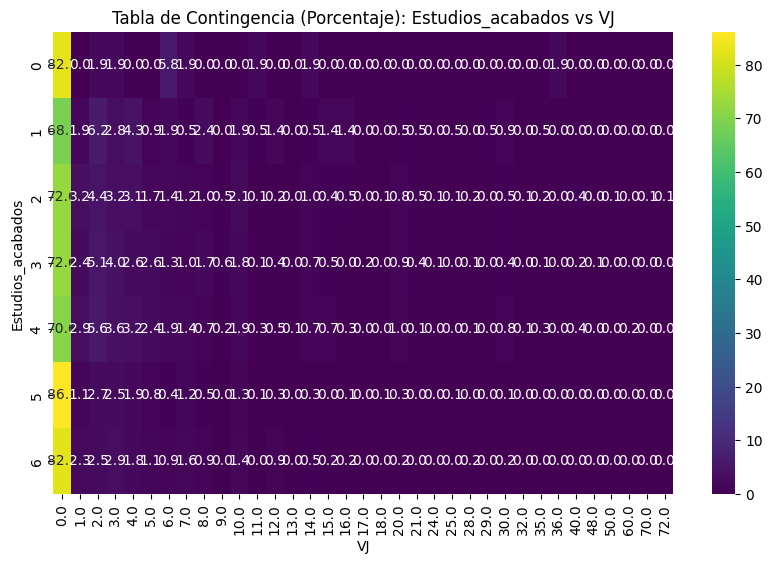

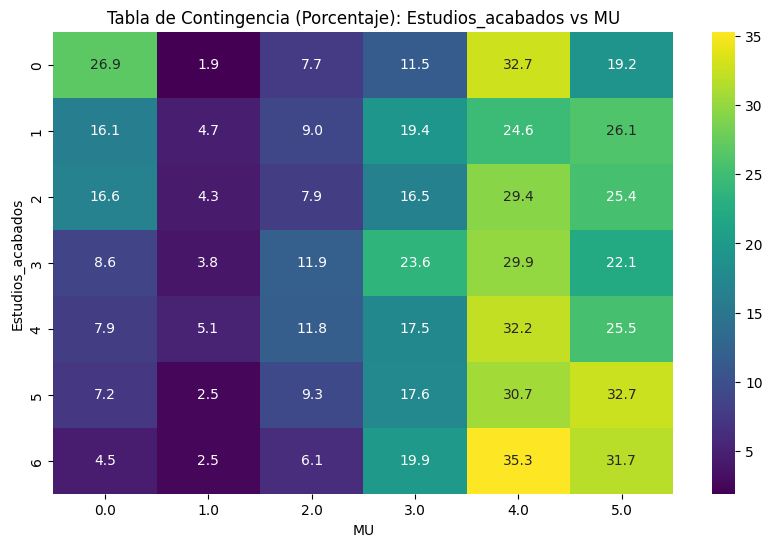

In [ ]:
top_resultados = resultados_significativos.head(5)

for index, row in top_resultados.iterrows():
    tabla_contingencia = pd.crosstab(epcc23[row['Variable']], epcc23[row['Target']])
    tabla_contingencia_porcentaje = tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0) * 100
    plt.figure(figsize=(10, 6))
    sns.heatmap(tabla_contingencia_porcentaje, annot=True, fmt='.1f', cmap='viridis')
    plt.title(f'Tabla de Contingencia (Porcentaje): {row["Variable"]} vs {row["Target"]}')
    plt.xlabel(row["Target"])
    plt.ylabel(row["Variable"])
    plt.show()

En estas tablas vemos que cuando las escalas de medición de los targets son muy amplias, es más complicado el análisis, por un lado, y además la mayoría de los valores se acumular a la izquierda en torno a los valores más bajos y más habituales de los targets, como las horas de videojuegos.

Otras tablas sí que resultan más interesantes como la de las horas de música en relación a las personas con las que se convive o con los estudios acabados.

Por ejemplo, las parejas con hijos y los hogares con 2 o más núcleos familiares son quienes más horas de música escuchan, y en la siguiente franja de escucha encontramos de nuevo las parejas con hijos, personas que viven solas o donde conviven 2 o más adultos, pero las parejas sin hijos tienden a escuchar menos.

También las personas con estudios universitarios y post universitarios dedican bastante mas horas que los demás a escuchar música, mientras que quienes no acabaron los estudios obligatorios le dedican muchas menos horas.

También madre o padre con hijos parecerían ir más seguido al cine que el resto, mientras que los que viven solos o las parejas sin hijos ven menos películas.


Ahora las numéricas

Veamos una matriz de correlación, con su correspodiente mapa de calor

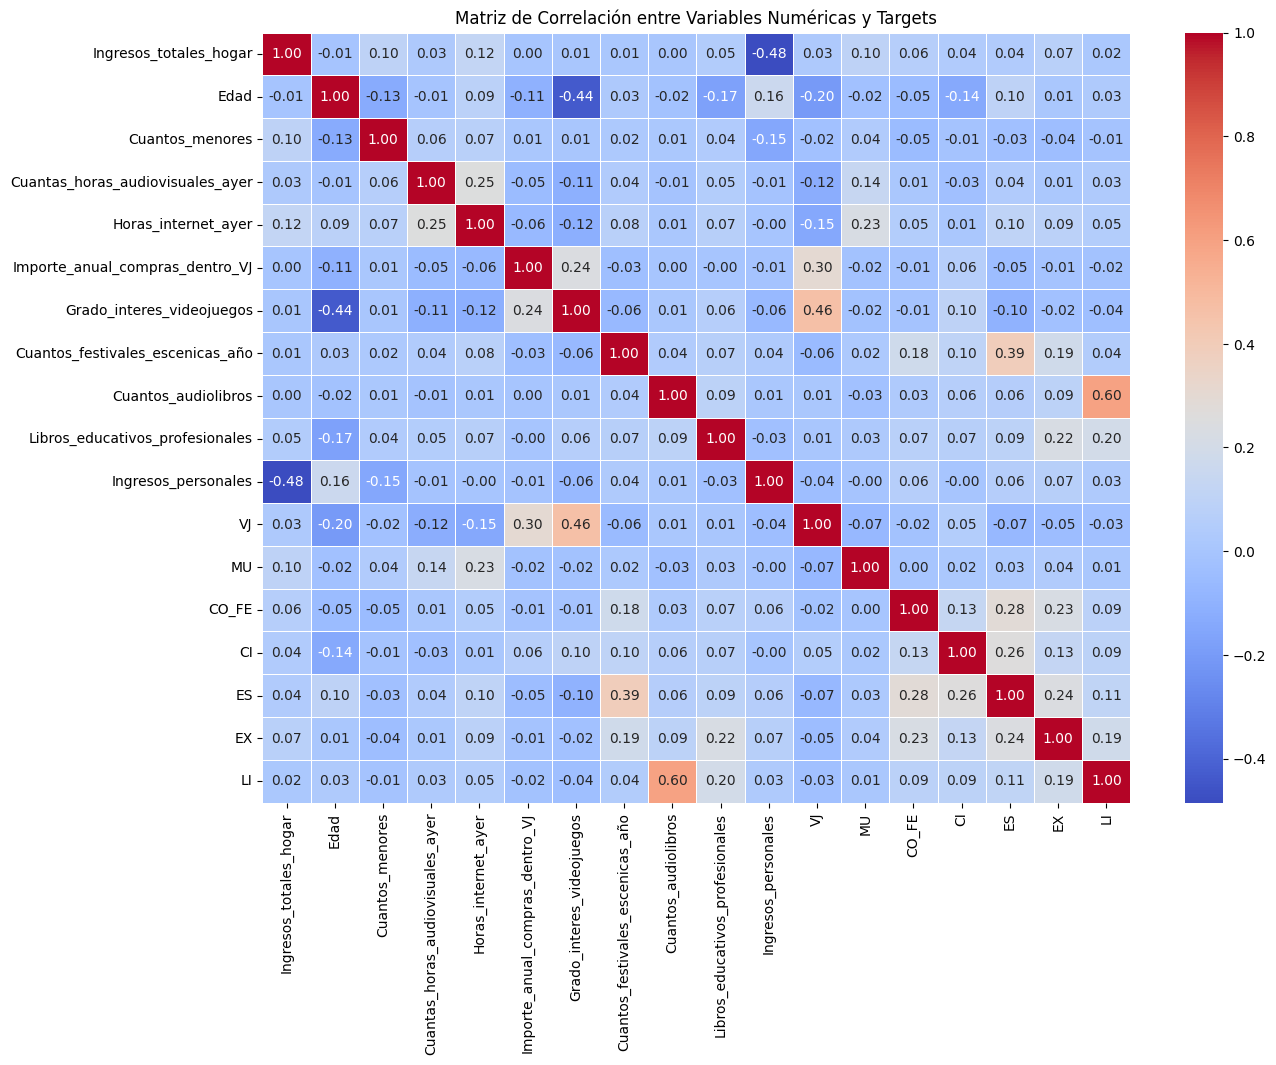

In [ ]:
num_and_targets = var_num + targets

# Crear un DataFrame solo con estas variables
df_num_and_targets = epcc23[num_and_targets]

# Calcular la matriz de correlación
correlation_matrix = df_num_and_targets.corr()

# Generar el heatmap de la matriz de correlación
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación entre Variables Numéricas y Targets')
plt.show()


En este caso vemos que hay algunas posibles colinealidades, como los ingresos individuales con los totales del hogar, los audiolibros con la cantidad de libros leídos o los festivales de escénicas con la frecuencia de espectáculos

Trabajo de las variables para la predicción

Algunas de mis variables contienen listas (cuando la pregunta permitía más de una respuesta), por lo que tengo que tratar estas variables primero.

Con esta función, las columnas que contengan listas automáticamante quedarán seleccionadas y se les aplicará la expansión para incluir solo un valor por columna.

In [ ]:
def convertir_cadena_a_lista(cadena):
    if isinstance(cadena, str):
        cadena = cadena.replace('[', '').replace(']', '')
        return [float(i) for i in cadena.split(',')]
    return cadena

# Aplicar la conversión a todas las columnas que contienen listas
columnas_con_listas = [col for col in epcc23.columns if epcc23[col].apply(lambda x: isinstance(x, str) and '[' in x and ']' in x).any()]

for col in columnas_con_listas:
    epcc23[col] = epcc23[col].apply(convertir_cadena_a_lista)

# Expandir las columnas con listas
columnas_expandidas = []
for col in columnas_con_listas:
    max_len = epcc23[col].apply(len).max()
    cols = [f'{col}_{i}' for i in range(max_len)]
    df_temp = pd.DataFrame(epcc23[col].tolist(), index=epcc23.index, columns=cols)
    df_temp = df_temp.fillna(0)  # Llenar NaNs con 0s después de la expansión
    epcc23 = pd.concat([epcc23, df_temp], axis=1)
    columnas_expandidas.extend(cols)
    epcc23.drop(columns=[col], inplace=True)

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
epcc23 = pd.DataFrame(imputer.fit_transform(epcc23), columns=epcc23.columns)

In [ ]:
non_numeric_columns = epcc23.select_dtypes(exclude=[np.number]).columns
print("Columnas no numéricas:", non_numeric_columns)

# Convertir columnas no numéricas a numéricas
for col in non_numeric_columns:
    try:
        epcc23[col] = epcc23[col].apply(lambda x: convertir_cadena_a_lista(x) if isinstance(x, str) else x)
        epcc23[col] = pd.to_numeric(epcc23[col], errors='coerce')
    except:
        print(f"Error al convertir la columna {col} a numérica")

# Asegurarse de que no haya valores NaN antes de escalar
epcc23.fillna(0, inplace=True)

# Verificar de nuevo si todas las columnas son numéricas
non_numeric_columns = epcc23.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    print("Aún hay columnas no numéricas:", non_numeric_columns)
else:
    print("Todas las columnas son numéricas.")


Columnas no numéricas: Index(['Idioma_preferencia', 'Residencia_habitual', 'Quienes_conviven',
       'Cuantos_menores', 'Cuantas_horas_audiovisuales_ayer',
       'Horas_internet_ayer', 'Grado_interes_videojuegos',
       'Media_horas_juego_semanal', 'Multijugador', 'Juego_nocturno',
       ...
       'EX', 'LI', 'Lengua_uso', 'Estudios_padres', 'Motivos_no', 'Con_quien',
       'valores_positivos_videojuegos_0', 'valores_positivos_videojuegos_1',
       'valores_negativos_videojuegos_0', 'valores_negativos_videojuegos_1'],
      dtype='object', length=130)
Todas las columnas son numéricas.


Por supuesto, tocará hacer el escalado

In [ ]:
scaler = StandardScaler()
epcc23 = pd.DataFrame(scaler.fit_transform(epcc23), columns=epcc23.columns)

In [ ]:
print(epcc23.isnull().sum().sum())  # Esto debería imprimir 0 si no hay valores faltantes
print(epcc23.head())

0
   Idioma_preferencia  Residencia_habitual  Quienes_conviven  Cuantos_menores  \
0            1.125177             0.030304          0.343398         1.198149   
1            1.125177             0.030304          0.343398         0.343959   
2           -0.880065             0.030304          0.343398         1.198149   
3           -0.880065             0.030304          1.027037         1.198149   
4           -0.880065             0.030304         -2.391159        -0.510230   

   Cuantas_horas_audiovisuales_ayer  Horas_internet_ayer  \
0                         -0.609180            -0.160206   
1                         -0.609180             0.566639   
2                         -0.609180            -0.160206   
3                          1.106614            -0.160206   
4                          0.248717            -0.160206   

   Grado_interes_videojuegos  Media_horas_juego_semanal  Multijugador  \
0                   1.639769                   0.037537      1.850603   
1   

Train y Test

In [ ]:
X = epcc23.drop(columns= var_targets + targets)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(epcc23, epcc23[targets], test_size=0.2, random_state=42, shuffle=True)

for target in targets:
    train_df[target] = epcc23.loc[X_train.index, target]
    test_df[target] = epcc23.loc[X_test.index, target]


In [ ]:
X_train

,Idioma_preferencia,Residencia_habitual,Quienes_conviven,Cuantos_menores,Cuantas_horas_audiovisuales_ayer,Horas_internet_ayer,Grado_interes_videojuegos,Media_horas_juego_semanal,Multijugador,Juego_nocturno,...,EX,LI,Lengua_uso,Estudios_padres,Motivos_no,Con_quien,valores_positivos_videojuegos_0,valores_positivos_videojuegos_1,valores_negativos_videojuegos_0,valores_negativos_videojuegos_1
468,-0.880065,0.030304,-1.023881,-0.510230,0.248717,1.293483,1.342751,-0.343383,1.850603,-0.435488,...,0.748346,-0.220092,-0.541877,1.117087,0.0,0.992742,-0.375705,-0.493969,-0.394991,-0.426019
561,1.125177,0.030304,-1.023881,-0.510230,-0.609180,-2.340741,-0.142338,0.037537,1.850603,2.296272,...,-0.617503,-0.479153,0.062739,-0.860037,0.0,-0.661493,-0.407087,-0.438615,-0.338772,-0.426019
1871,1.125177,-1.419693,0.343398,-0.510230,0.248717,-0.160206,1.342751,-0.343383,-0.540364,2.296272,...,-0.344334,0.298030,1.271971,1.776128,0.0,0.992742,-0.375705,2.218416,-0.451209,-0.332688
2083,1.125177,0.030304,1.027037,-0.510230,0.248717,1.293483,-0.736373,-0.343383,-0.540364,-0.435488,...,-0.617503,-0.090561,0.667355,-0.200996,0.0,-0.661493,-0.375705,-0.383260,-0.479318,-0.301578
3679,-0.880065,0.030304,-1.707520,-0.510230,0.248717,1.293483,-1.033391,-0.343383,-0.540364,-0.435488,...,1.158101,-0.090561,-0.541877,-0.200996,0.0,-0.661493,2.637010,-0.521647,2.275384,-0.457130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,1.125177,0.030304,-0.340241,-0.510230,-0.609180,0.566639,0.451698,1.561215,1.850603,2.296272,...,-0.207749,-0.479153,0.667355,-0.860037,0.0,0.992742,-0.438470,-0.410937,-0.423100,-0.426019
466,1.125177,0.030304,-1.023881,-0.510230,1.964511,1.293483,0.748716,-0.343383,-0.540364,-0.435488,...,2.114196,-0.349622,0.062739,0.458046,0.0,0.992742,-0.375705,-0.466292,-0.479318,-0.270467
3092,1.125177,2.205299,-1.023881,-0.510230,-2.324973,-1.613896,1.936787,0.418456,1.850603,2.296272,...,-0.207749,-0.479153,1.271971,-0.860037,0.0,-0.661493,-0.312940,-0.410937,-0.479318,2.622796
3772,-0.880065,1.480300,0.343398,2.052338,0.248717,0.566639,-1.033391,-0.343383,-0.540364,-0.435488,...,-0.071164,0.038969,-1.146493,1.117087,0.0,0.992742,-0.375705,2.218416,-0.479318,-0.332688


In [ ]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Tamaño de train_df:", train_df.shape)
print("Tamaño de test_df:", test_df.shape)

Tamaño del conjunto de entrenamiento: (3292, 130)
Tamaño del conjunto de prueba: (823, 130)
Tamaño de train_df: (3292, 121)
Tamaño de test_df: (823, 121)


Modelado

In [ ]:
model_names = ["Regresion Lineal", "Gradient Boosting", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]
lr_reg = LinearRegression()
gb_reg = GradientBoostingRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42)
lgb_reg = LGBMRegressor(random_state=42, verbose=-100)
cat_reg = CatBoostRegressor(random_state=42, verbose=False)

model_set = [lr_reg, gb_reg, rf_reg, xgb_reg, lgb_reg, cat_reg]

In [ ]:
y_train_1 = y_train['MU']

metricas_cv = {}
valores = []
for nombre, modelo in zip(model_names, model_set):
    print(f"Evaluando {nombre}")
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))

ganador = list(metricas_cv.keys())[np.argmax(valores)]
print(f"Mejor modelo: {ganador}")

Evaluando Regresion Lineal
Evaluando Gradient Boosting
Evaluando Random Forest
Evaluando XGBoost
Evaluando LightGBM
Evaluando CatBoost
Mejor modelo: Regresion Lineal


In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAE_CV: {np.mean(-valores)}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, MAE_CV: 1.08727496574097e-15
Model <Gradient Boosting>, MAE_CV: 2.1818077139247657e-05
Model <Random Forest>, MAE_CV: 1.4228831605120537e-15
Model <XGBoost>, MAE_CV: 1.731986590636101e-05
Model <LightGBM>, MAE_CV: 2.1828912908953478e-05
Model <CatBoost>, MAE_CV: 0.00525898415725774
El ganador es Regresion Lineal


Vale... pero a ver si puedo mejorar el segundo mejor, el Random Forest

---



In [ ]:
# Optimización para la regresión lineal
lr_reg = LinearRegression()

# Definir la cuadrícula de parámetros para GridSearchCV
params_grid_lr = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

# Configurar GridSearchCV para regresión lineal
lr_grid = GridSearchCV(lr_reg,
                       param_grid=params_grid_lr,
                       cv=3,
                       scoring="neg_mean_absolute_error",
                       n_jobs=-1)

# Ajustar GridSearchCV para regresión lineal
lr_grid.fit(X_train, y_train['MU'])

# Imprimir los mejores parámetros y la mejor puntuación para regresión lineal
print("Mejores parámetros para Regresión Lineal: ", lr_grid.best_params_)
print("Mejor puntuación para Regresión Lineal: ", lr_grid.best_score_)


Mejores parámetros para Regresión Lineal:  {'copy_X': True, 'fit_intercept': False, 'positive': True}
Mejor puntuación para Regresión Lineal:  -2.809400222969991e-17


In [ ]:
rf_reg = RandomForestRegressor(random_state=42)

# Definir la cuadrícula de parámetros para GridSearchCV
params_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
}

# Configurar GridSearchCV para Random Forest
rf_grid = GridSearchCV(rf_reg,
                       param_grid=params_grid_rf,
                       cv=3,
                       scoring="neg_mean_absolute_error",
                       n_jobs=-1)

# Ajustar GridSearchCV para Random Forest
rf_grid.fit(X_train, y_train['MU'])

# Imprimir los mejores parámetros y la mejor puntuación para Random Forest
print("Mejores parámetros para Random Forest: ", rf_grid.best_params_)
print("Mejor puntuación para Random Forest: ", rf_grid.best_score_)

Mejores parámetros para Random Forest:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación para Random Forest:  -1.4228831605120537e-15


A pesar de mis intentos de perfeccionar un modelo más "sofisticado" como Random Forest, la sencilla regresión Lineal nosda mejores resultados y ese es el modelo con el que me quedo para esta predicción.

Probaré ahora con los otros targets

In [ ]:
y_train_2 = y_train['VJ']

metricas_cv = {}
valores = []
for nombre, modelo in zip(model_names, model_set):
    print(f"Evaluando {nombre}")
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))

ganador = list(metricas_cv.keys())[np.argmax(valores)]
print(f"Mejor modelo: {ganador}")

Evaluando Regresion Lineal
Evaluando Gradient Boosting
Evaluando Random Forest
Evaluando XGBoost
Evaluando LightGBM
Evaluando CatBoost
Mejor modelo: Regresion Lineal


In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAE_CV: {np.mean(-valores)}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, MAE_CV: 1.08727496574097e-15
Model <Gradient Boosting>, MAE_CV: 2.1818077139247657e-05
Model <Random Forest>, MAE_CV: 1.4228831605120537e-15
Model <XGBoost>, MAE_CV: 1.731986590636101e-05
Model <LightGBM>, MAE_CV: 2.1828912908953478e-05
Model <CatBoost>, MAE_CV: 0.00525898415725774
El ganador es Regresion Lineal


De nuevo la Regresión Lineal gana

In [ ]:
y_train_3 = y_train['CI']

metricas_cv = {}
valores = []
for nombre, modelo in zip(model_names, model_set):
    print(f"Evaluando {nombre}")
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))

ganador = list(metricas_cv.keys())[np.argmax(valores)]
print(f"Mejor modelo: {ganador}")

Evaluando Regresion Lineal
Evaluando Gradient Boosting
Evaluando Random Forest
Evaluando XGBoost
Evaluando LightGBM
Evaluando CatBoost
Mejor modelo: Regresion Lineal


In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAE_CV: {np.mean(-valores)}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, MAE_CV: 1.08727496574097e-15
Model <Gradient Boosting>, MAE_CV: 2.1818077139247657e-05
Model <Random Forest>, MAE_CV: 1.4228831605120537e-15
Model <XGBoost>, MAE_CV: 1.731986590636101e-05
Model <LightGBM>, MAE_CV: 2.1828912908953478e-05
Model <CatBoost>, MAE_CV: 0.00525898415725774
El ganador es Regresion Lineal


In [ ]:
y_train_4 = y_train['ES']

metricas_cv = {}
valores = []
for nombre, modelo in zip(model_names, model_set):
    print(f"Evaluando {nombre}")
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))

ganador = list(metricas_cv.keys())[np.argmax(valores)]
print(f"Mejor modelo: {ganador}")

Evaluando Regresion Lineal
Evaluando Gradient Boosting
Evaluando Random Forest
Evaluando XGBoost
Evaluando LightGBM
Evaluando CatBoost
Mejor modelo: Regresion Lineal


In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAE_CV: {np.mean(-valores)}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, MAE_CV: 1.08727496574097e-15
Model <Gradient Boosting>, MAE_CV: 2.1818077139247657e-05
Model <Random Forest>, MAE_CV: 1.4228831605120537e-15
Model <XGBoost>, MAE_CV: 1.731986590636101e-05
Model <LightGBM>, MAE_CV: 2.1828912908953478e-05
Model <CatBoost>, MAE_CV: 0.00525898415725774
El ganador es Regresion Lineal


In [ ]:
y_train_5 = y_train['EX']

metricas_cv = {}
valores = []
for nombre, modelo in zip(model_names, model_set):
    print(f"Evaluando {nombre}")
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))

ganador = list(metricas_cv.keys())[np.argmax(valores)]
print(f"Mejor modelo: {ganador}")

Evaluando Regresion Lineal
Evaluando Gradient Boosting
Evaluando Random Forest
Evaluando XGBoost
Evaluando LightGBM
Evaluando CatBoost
Mejor modelo: Regresion Lineal


In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAE_CV: {np.mean(-valores)}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, MAE_CV: 1.08727496574097e-15
Model <Gradient Boosting>, MAE_CV: 2.1818077139247657e-05
Model <Random Forest>, MAE_CV: 1.4228831605120537e-15
Model <XGBoost>, MAE_CV: 1.731986590636101e-05
Model <LightGBM>, MAE_CV: 2.1828912908953478e-05
Model <CatBoost>, MAE_CV: 0.00525898415725774
El ganador es Regresion Lineal


In [ ]:
y_train_6 = y_train['LI']

metricas_cv = {}
valores = []
for nombre, modelo in zip(model_names, model_set):
    print(f"Evaluando {nombre}")
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))

ganador = list(metricas_cv.keys())[np.argmax(valores)]
print(f"Mejor modelo: {ganador}")

Evaluando Regresion Lineal
Evaluando Gradient Boosting
Evaluando Random Forest
Evaluando XGBoost
Evaluando LightGBM
Evaluando CatBoost
Mejor modelo: Regresion Lineal


In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAE_CV: {np.mean(-valores)}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, MAE_CV: 1.08727496574097e-15
Model <Gradient Boosting>, MAE_CV: 2.1818077139247657e-05
Model <Random Forest>, MAE_CV: 1.4228831605120537e-15
Model <XGBoost>, MAE_CV: 1.731986590636101e-05
Model <LightGBM>, MAE_CV: 2.1828912908953478e-05
Model <CatBoost>, MAE_CV: 0.00525898415725774
El ganador es Regresion Lineal


In [ ]:
y_train_7 = y_train['CO_FE']

metricas_cv = {}
valores = []
for nombre, modelo in zip(model_names, model_set):
    print(f"Evaluando {nombre}")
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train_example, cv=3, scoring="neg_mean_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))

ganador = list(metricas_cv.keys())[np.argmax(valores)]
print(f"Mejor modelo: {ganador}")

Evaluando Regresion Lineal
Evaluando Gradient Boosting
Evaluando Random Forest
Evaluando XGBoost
Evaluando LightGBM
Evaluando CatBoost
Mejor modelo: Regresion Lineal


In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAE_CV: {np.mean(-valores)}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, MAE_CV: 1.08727496574097e-15
Model <Gradient Boosting>, MAE_CV: 2.1818077139247657e-05
Model <Random Forest>, MAE_CV: 1.4228831605120537e-15
Model <XGBoost>, MAE_CV: 1.731986590636101e-05
Model <LightGBM>, MAE_CV: 2.1828912908953478e-05
Model <CatBoost>, MAE_CV: 0.00525898415725774
El ganador es Regresion Lineal


In [ ]:
lr_reg.fit(X_train, y_train)

# Predecir en el conjunto de prueba para cada target
predicciones_test = lr_reg.predict(X_test)

# Calcular y mostrar el MAE para cada target en el conjunto de prueba
for i, target in enumerate(target_names):
    mae_test = mean_absolute_error(y_test[target], predicciones_test[:, i])
    print(f"MAE para {target} en el conjunto de prueba: {mae_test}")

MAE para VJ en el conjunto de prueba: 1.06325269906177e-15
MAE para MU en el conjunto de prueba: 1.0712033393429176e-15
MAE para CO_FE en el conjunto de prueba: 1.137367336804536e-15
MAE para CI en el conjunto de prueba: 1.0809161045644257e-15
MAE para ES en el conjunto de prueba: 1.2987408839743833e-15
MAE para EX en el conjunto de prueba: 1.1391252461349913e-15
MAE para LI en el conjunto de prueba: 9.606784788492118e-16


El error que arroja la predicción para cada uno de los casos es bajo... muy bajo... Y es sospechoso...
Lo siguiente debería ser analizar porqué, si hay overfitting o porqué es tan acertado...

A ver todas las métricas para todoslos targets:

In [ ]:
best_model = LinearRegression(copy_X=True, fit_intercept=False, positive=True)

# Diccionario para almacenar los resultados
resultados_test = {}

# Iterar sobre cada target y calcular las métricas
for target in targets_agrupados:
    best_model.fit(X_train, y_train[target])
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test[target], y_pred)
    mape = mean_absolute_percentage_error(y_test[target], y_pred)
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))

    resultados_test[target] = {
        "MAE": mae,
        "MAPE": mape,
        "RMSE": rmse
    }

# Imprimir los resultados
for target, metricas in resultados_test.items():
    print(f"Resultados para {target}:")
    print(f"MAE: {metricas['MAE']}")
    print(f"MAPE: {metricas['MAPE']}")
    print(f"RMSE: {metricas['RMSE']}")
    print()

Resultados para VJ:
MAE: 8.903368119715715e-18
MAPE: 4.7567272393558926e-18
RMSE: 5.869136771411203e-17

Resultados para MU:
MAE: 1.0688763226752646e-15
MAPE: 1.3260559191547484e-15
RMSE: 1.3243199822727376e-15

Resultados para CO_FE:
MAE: 1.1469747117784148e-14
MAPE: 2.4493979029315067e-14
RMSE: 2.0412352897236372e-14

Resultados para CI:
MAE: 7.308181331599982e-17
MAPE: 1.2151443390911834e-16
RMSE: 1.1018869777433531e-16

Resultados para ES:
MAE: 4.2603375262622623e-16
MAPE: 8.263423080724934e-16
RMSE: 7.001892967881974e-16

Resultados para EX:
MAE: 2.0477746675346144e-16
MAPE: 6.558191395857935e-16
RMSE: 4.656116278589797e-16

Resultados para LI:
MAE: 3.874988624830817e-17
MAPE: 8.49414610759076e-17
RMSE: 8.627027801583652e-17



In [ ]:
import joblib

joblib.dump(best_model, 'best_model_regresion_lineal.pkl')
print("Modelo guardado como 'best_model_regresion_lineal_EPCC23.pkl'")

Modelo guardado como 'best_model_regresion_lineal_EPCC23.pkl'
